In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import tensorflow as tf
from livelossplot import PlotLossesKeras
np.random.seed(7)
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from keras.preprocessing import sequence
from gensim.models import Word2Vec, KeyedVectors, word2vec
import gensim
from gensim.utils import simple_preprocess
from tensorflow.keras.utils import to_categorical
import pickle
import h5py
from time import time

In [2]:
#filename = 'C:/Users/Bartosz/OneDrive/magisterka semestr 3/UM/projekt nlp/ml-agh-course/data/polish_sentiment_dataset.csv'
filename = 'C:/Users/Bartosz/OneDrive/magisterka semestr 3/UM/dane_nowe.csv'
dataset = pd.read_csv(filename, delimiter = ";")

# Delete unused column
#del dataset['length']

# Delete All NaN values from columns=['description','rate']
dataset = dataset[dataset['description'].notnull() & dataset['rate'].notnull()]

# We set all strings as lower case letters
#dataset['description'] = dataset['description'].str.lower()



In [176]:
#class_names = ["Neutral","Positive", "Negative"]

In [3]:
dataset.head()

,description,rate
0,Sprawdzane będzie funkcjonowanie tej zastawki...,0.0
1,Obce sobie osoby muszą spać razem na sofach ( ...,-1.0
2,"Nie jest ona łatwa , zwykle podejrzenie złośli...",0.0
3,Bardzo miła i fachowa obsługa .,1.0
4,"Jest to osoba , która potrafi w trakcie proces...",1.0


In [4]:
print(dataset.count())

temp = dataset.groupby('rate').count()['description'].reset_index().sort_values(by='description',ascending=False)

print(temp)

description    110104
rate           110104
dtype: int64
   rate  description
0  -1.0        43799
2   1.0        36955
1   0.0        29350


In [179]:
#making dataset more symmetric

dataset_negative = dataset[dataset['rate'] == -1.0]
print(dataset_negative.count())
dataset_positive = dataset[dataset['rate'] == 1.0]
print(dataset_positive.count())
dataset_neutral = dataset[dataset['rate'] == 0.0]
print(dataset_neutral.count())

dataset_positive_cut=dataset_positive[:183391]
print(dataset_positive_cut.count())



description    43799
rate           43799
dtype: int64
description    36955
rate           36955
dtype: int64
description    29350
rate           29350
dtype: int64
description    36955
rate           36955
dtype: int64


In [64]:
##making dataset more symmetric

print(dataset_positive_cut.count())
frames = [dataset_positive_cut, dataset_negative, dataset_neutral]

dataset = pd.concat(frames)
print(dataset.count())

description    183391
rate           183391
dtype: int64
description    385329
rate           385329
dtype: int64


In [5]:
stop_words_path = 'C:/Users/Bartosz/OneDrive/magisterka semestr 3/UM/polishstopwords.txt'


stop_words = pd.read_csv(stop_words_path, sep=" ", header=None)
stop_words.columns = ["word"]

stop_words.head()

stop_words = stop_words["word"].tolist()

print(stop_words)

['a', 'aby', 'ach', 'acz', 'aczkolwiek', 'aj', 'albo', 'ale', 'alez', 'ależ', 'ani', 'az', 'aż', 'bardziej', 'bardzo', 'beda', 'bedzie', 'bez', 'deda', 'będą', 'bede', 'będę', 'będzie', 'bo', 'bowiem', 'by', 'byc', 'być', 'byl', 'byla', 'byli', 'bylo', 'byly', 'był', 'była', 'było', 'były', 'bynajmniej', 'cala', 'cali', 'caly', 'cała', 'cały', 'ci', 'cie', 'ciebie', 'cię', 'co', 'cokolwiek', 'cos', 'coś', 'czasami', 'czasem', 'czemu', 'czy', 'czyli', 'daleko', 'dla', 'dlaczego', 'dlatego', 'do', 'dobrze', 'dokad', 'dokąd', 'dosc', 'dość', 'duzo', 'dużo', 'dwa', 'dwaj', 'dwie', 'dwoje', 'dzis', 'dzisiaj', 'dziś', 'gdy', 'gdyby', 'gdyz', 'gdyż', 'gdzie', 'gdziekolwiek', 'gdzies', 'gdzieś', 'go', 'i', 'ich', 'ile', 'im', 'inna', 'inne', 'inny', 'innych', 'iz', 'iż', 'ja', 'jak', 'jakas', 'jakaś', 'jakby', 'jaki', 'jakichs', 'jakichś', 'jakie', 'jakis', 'jakiś', 'jakiz', 'jakiż', 'jakkolwiek', 'jako', 'jakos', 'jakoś', 'ją', 'je', 'jeden', 'jedna', 'jednak', 'jednakze', 'jednakże', 'jedno'

In [181]:
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    #lowecasre
    text = str(text).lower()
    #remove text in square brackets
    text = re.sub('\[.*?\]', '', text)
    #remove links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    #remove punctuation and words containing numbers
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    #removing stop words
    tokens = []
    for token in text.split():
        if token not in stop_words:
                tokens.append(token)
    return " ".join(tokens)
    

test = "hej, nie co tam i albo aczkolwiek, polska gola lewandowski"

print(clean_text(test))
    


hej nie polska gola lewandowski


In [ ]:
#text preprocessing

dataset['description'] = dataset['description'].apply(lambda x:clean_text(x))

dataset.head()

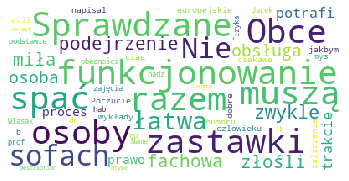

In [11]:
from wordcloud import WordCloud
#from many_stop_words import get_stop_words

#stop_words = get_stop_words('pl')

wordcloud = WordCloud(
                    background_color='white',
                    stopwords=stop_words,
                    max_words=100,
                    max_font_size=40,
                    random_state=42
).generate(str(dataset['description']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('Plots/woirdcloud.png')
plt.show()

In [16]:
from collections import Counter

dataset['description'] = dataset['description'].apply(lambda x:str(x).split())
top = Counter([item for sublist in dataset['description'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,"'.',",332154
2,"'i',",137273
3,"'w',",132718
4,"'na',",111800
5,"'nie',",109296
6,"'z',",91484
7,'.'],91375
8,"'się',",84504
9,"'do',",65852
10,"'to',",62957


In [8]:
X = dataset['description']
y = dataset['rate']

#splitting dataset to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#splitting train to train and validate
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [184]:
print(y_train)
print(y_val)

109777    1.0
11304    -1.0
76598     0.0
58760    -1.0
98306     1.0
         ... 
78665     0.0
2140     -1.0
74391     1.0
21445    -1.0
15664     1.0
Name: rate, Length: 70466, dtype: float64
31426    1.0
61539    0.0
87421   -1.0
9127     0.0
68976    1.0
        ... 
22732    0.0
81696    1.0
71122    0.0
87196   -1.0
58070   -1.0
Name: rate, Length: 17617, dtype: float64


In [192]:
dataset.shape

(110104, 2)

dlugosc poszczegolnych zbiorow


In [194]:
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("X_val shape: " + str(X_val.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))
print("y_val shape: " + str(y_val.shape))


X_train shape: (70466,)
X_test shape: (22021,)
X_val shape: (17617,)
y_train shape: (70466,)
y_test shape: (22021,)
y_val shape: (17617,)


In [195]:
y_val

31426    1.0
61539    0.0
87421   -1.0
9127     0.0
68976    1.0
        ... 
22732    0.0
81696    1.0
71122    0.0
87196   -1.0
58070   -1.0
Name: rate, Length: 17617, dtype: float64

stworzenie wektoru słów na bazie modelu z polskiej akademii nauk


In [162]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('nkjp.txt', binary=False)



Zamiana syn0 na vectors


In [163]:
emb_mean, emb_std = word2vec_model.vectors.mean(), word2vec_model.vectors.std()



In [196]:
embedding_matrix = word2vec_model.vectors
print('Shape of embedding matrix: ', embedding_matrix.shape)

Shape of embedding matrix:  (2123132, 100)


test

In [165]:
word2vec_model.most_similar("siema")

[('stokrotka81', 0.7790719270706177),
 ('Siemka', 0.7777332067489624),
 ('hejka', 0.7680844664573669),
 ('siemanko', 0.7574141025543213),
 ('piotrus655', 0.7478634715080261),
 ('Cookiemonster', 0.7464573383331299),
 ('milusia32', 0.7438090443611145),
 ('kristoforo1956', 0.7392926812171936),
 ('Virusek', 0.7378849387168884),
 ('Hejka', 0.7295235395431519)]

Vectorize X_train and X_test to 2D tensor:

fit_on_texts Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value.

In [197]:
top_words = embedding_matrix.shape[0]
mxlen = 50
nb_classes = 3

tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)


texts_to_sequences Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary

In [198]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(word_index)



Found 82122 unique tokens.
{'nie': 1, 'm': 2, 'em': 3, 'śmy': 4, 'doktor': 5, 'hotelu': 6, 'polecam': 7, 'hotel': 8, 'dr': 9, 'niestety': 10, 'pokoju': 11, 'obsługa': 12, 'brak': 13, 'pokoje': 14, 'lekarza': 15, 'lekarz': 16, 'ok': 17, 'pokój': 18, 'badania': 19, '–': 20, 'miała': 21, 'raz': 22, 'jedzenie': 23, 'dzieci': 24, 'wizyty': 25, 'chyba': 26, 'doktora': 27, '„': 28, '”': 29, 'pacjenta': 30, 'czas': 31, 'miła': 32, 'recepcji': 33, 'miejsce': 34, 'wizyta': 35, 'wiem': 36, 'dobre': 37, 'wizycie': 38, 'leczenia': 39, 'naprawdę': 40, 'badań': 41, 'np': 42, 'osób': 43, 'proc': 44, 'restauracji': 45, 'basen': 46, 'centrum': 47, 'śniadania': 48, 'innego': 49, 'problem': 50, 'dzięki': 51, 'czasu': 52, 'trochę': 53, 'chodzi': 54, 'dni': 55, 'ogólnie': 56, 'dziecko': 57, 'mogę': 58, 'prof': 59, 'wrażenie': 60, 'wizytę': 61, 'minut': 62, 'duży': 63, 'okazało': 64, 'dzień': 65, 'badanie': 66, 'gości': 67, 'temu': 68, 'super': 69, 'śniadanie': 70, 'oczywiście': 71, 'usg': 72, 'leczenie': 73

In [199]:
print(X_train)

109777    mróz marcin mgr inż nie lepiej kurs fizyka lab...
11304          śniadanie zamówić niedostosowane ilości osób
76598     pewnego pięknego dnia otrzymawszy telefon szko...
58760     hotel totalna porazka dostalismy klucze pokoju...
98306     kolumny grają ładnie czysto nie męczą ucha poł...
                                ...                        
78665     centrum samochód wypadku obracał symulator des...
2140      okazalo maly wade genetyczna wiecej wazniejsze...
74391     ania życiową optymistką potrafi zaradzić każde...
21445     kobiet starających dziecko ciąży nie ogóle prz...
15664                                   gratuluję podziwiam
Name: description, Length: 70466, dtype: object


Pads sequences to the same length. Converts a class vector (integers) to binary class matrix.

In [200]:
X_train = sequence.pad_sequences(sequences_train, maxlen=mxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=mxlen)
X_val = sequence.pad_sequences(sequences_val, maxlen=mxlen)

#binary encoding
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)
y_val = np_utils.to_categorical(y_val, nb_classes)

X_train

array([[    0,     0,     0, ...,  1534, 10832, 12905],
       [    0,     0,     0, ..., 64496,   771,    43],
       [    0,     0,     0, ...,   379,  1599, 26829],
       ...,
       [    0,     0,     0, ...,   431, 15343,  7383],
       [    0,     0,     0, ...,  3025, 35511, 16052],
       [    0,     0,     0, ...,     0, 10013,  8965]])

In [201]:
print(y_train.shape)


print(y_train)

(70466, 3)
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [202]:
class_names = ["Neutral","Positive", "Negative"]

In [203]:
print(X_train)

[[    0     0     0 ...  1534 10832 12905]
 [    0     0     0 ... 64496   771    43]
 [    0     0     0 ...   379  1599 26829]
 ...
 [    0     0     0 ...   431 15343  7383]
 [    0     0     0 ...  3025 35511 16052]
 [    0     0     0 ...     0 10013  8965]]


creating  LST network model (kind of RNN)

In [209]:
batch_size = 32
nb_epoch = 15

embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128, recurrent_dropout=0.3, dropout=0.3))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         212313200 
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_3 (Activation)    (None, 3)                 0         
Total params: 212,430,835
Trainable params: 117,635
Non-trainable params: 212,313,200
_________________________________________________________________


We just need to compile the model and we will be ready to train it. When we compile the model, we declare the optimizer (Adam, SGD, etc.)  and the loss function. To fit the model, all we have to do is declare the number of epochs and the batch size.

nb_epochs renamed to epochs

In [210]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn = model.fit(X_train, y_train, epochs= 15, batch_size=batch_size, shuffle=True, validation_data=(X_val, y_val))
score = model.evaluate(X_val, y_val)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

Epoch 1/15
2203/2203 [==============================] - 156s 68ms/step - loss: 0.8755 - accuracy: 0.5928 - val_loss: 0.7283 - val_accuracy: 0.6950
Epoch 2/15
2203/2203 [==============================] - 151s 69ms/step - loss: 0.7197 - accuracy: 0.6890 - val_loss: 0.6503 - val_accuracy: 0.7371
Epoch 3/15
2203/2203 [==============================] - 147s 67ms/step - loss: 0.6646 - accuracy: 0.7196 - val_loss: 0.6086 - val_accuracy: 0.7517
Epoch 4/15
2203/2203 [==============================] - 148s 67ms/step - loss: 0.6332 - accuracy: 0.7335 - val_loss: 0.6009 - val_accuracy: 0.7606
Epoch 5/15
2203/2203 [==============================] - 149s 68ms/step - loss: 0.6071 - accuracy: 0.7447 - val_loss: 0.5413 - val_accuracy: 0.7823
Epoch 6/15
2203/2203 [==============================] - 144s 65ms/step - loss: 0.5931 - accuracy: 0.7527 - val_loss: 0.5393 - val_accuracy: 0.7796
Epoch 7/15
2203/2203 [==============================] - 144s 65ms/step - loss: 0.5821 - accuracy: 0.7572 - val_loss: 0

saving model


In [211]:
print('Save model...')
model.save('Models/finalsentimentmodelv3.h5')
print('Saved model to disk...')

print('Save Word index...')
output = open('Models/finalwordindexv3.pkl', 'wb')
pickle.dump(word_index, output)
print('Saved word index to disk...')

Save model...
Saved model to disk...
Save Word index...
Saved word index to disk...


{'loss': [0.8754821419715881, 0.7196699976921082, 0.6645832657814026, 0.6331935524940491, 0.6071364283561707, 0.5931472778320312, 0.5820673704147339, 0.5717994570732117, 0.5657018423080444, 0.5587019324302673, 0.5543521046638489, 0.5495803356170654, 0.5485208630561829, 0.546014130115509, 0.5410274863243103], 'accuracy': [0.592768132686615, 0.688984751701355, 0.7196378111839294, 0.7335310578346252, 0.7447421550750732, 0.752660870552063, 0.7572446465492249, 0.7626089453697205, 0.7669230699539185, 0.7682995796203613, 0.7700309157371521, 0.7736496925354004, 0.7723724842071533, 0.7741889953613281, 0.7760338187217712], 'val_loss': [0.7282828092575073, 0.6503331661224365, 0.6086081266403198, 0.6008998155593872, 0.5412541031837463, 0.5393262505531311, 0.5231161117553711, 0.5292730927467346, 0.5131402611732483, 0.5045629739761353, 0.5158539414405823, 0.4967990815639496, 0.4875544607639313, 0.49516648054122925, 0.48869478702545166], 'val_accuracy': [0.6950104832649231, 0.7371289134025574, 0.7517

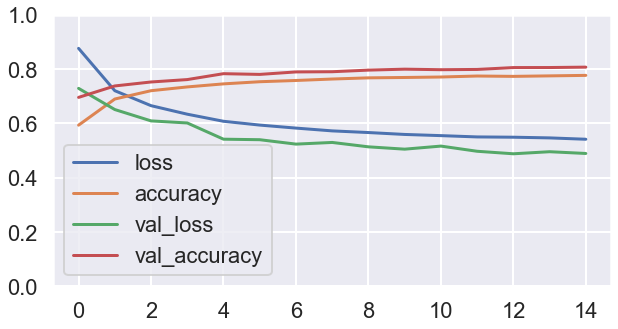

In [214]:
print(rnn.history)
pd.DataFrame(rnn.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

krzywe uczenia


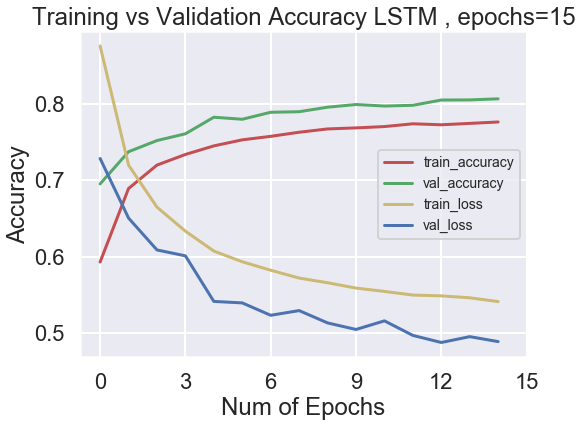

In [226]:
plt.figure(0)
plt.plot(rnn.history['accuracy'],'r')
plt.plot(rnn.history['val_accuracy'],'g')
plt.plot(rnn.history['loss'],'y')
plt.plot(rnn.history['val_loss'],'b')
plt.xticks(np.arange(0, nb_epoch+1, nb_epoch/5))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy LSTM , epochs=15") # for max length = 10 and 20 epochs
plt.legend(['train_accuracy', 'val_accuracy','train_loss', 'val_loss'], loc=5, prop={'size': 14})

# plt.figure(1)
# plt.plot(rnn.history['loss'],'r')
# plt.plot(rnn.history['val_loss'],'g')
# plt.xticks(np.arange(0, nb_epoch+1, nb_epoch/5))
# plt.rcParams['figure.figsize'] = (8, 6)
# plt.xlabel("Num of Epochs")
# plt.ylabel("Training vs Validation Loss LSTM, epochs=15") # for max length = 10 and 20 epochs
# plt.legend(['train', 'validation'])
plt.savefig('Plots/accuracy_loss.png')
plt.show()

In [229]:
# Apply Precision-Recall

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)

# Convert Y_Test into 1D array
yy_true = [np.argmax(i) for i in y_test]
print(yy_true)

yy_scores = [np.argmax(i) for i in y_pred]
print(yy_scores)

print("Recall: " + str(round(recall_score(yy_true, yy_scores, average='weighted'),2)))
print("Precision: " + str(round(precision_score(yy_true, yy_scores, average='weighted'),2)))
print("F1 Score: " + str(round(f1_score(yy_true, yy_scores, average='weighted'),2)))

[1, 0, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0, 1, 2, 1, 2, 0, 2, 1, 1, 2, 0, 1, 2, 2, 1, 0, 1, 1, 0, 1, 2, 1, 2, 2, 2, 0, 2, 2, 1, 0, 1, 2, 1, 2, 1, 2, 0, 2, 2, 2, 0, 2, 1, 1, 2, 0, 1, 0, 0, 2, 2, 2, 2, 1, 2, 0, 0, 0, 0, 0, 2, 1, 1, 1, 0, 0, 2, 2, 1, 2, 1, 1, 1, 2, 1, 0, 0, 2, 2, 0, 1, 1, 2, 0, 2, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 1, 1, 0, 2, 1, 0, 2, 0, 0, 1, 2, 0, 2, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 0, 2, 2, 2, 2, 1, 0, 1, 1, 1, 0, 1, 0, 2, 2, 1, 0, 0, 1, 0, 1, 2, 1, 2, 2, 2, 1, 2, 1, 0, 0, 0, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 0, 1, 2, 2, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 2, 2, 0, 1, 0, 2, 1, 1, 2, 2, 0, 2, 2, 2, 0, 0, 2, 1, 2, 1, 1, 1, 2, 0, 2, 1, 1, 2, 0, 1, 2, 0, 1, 2, 1, 1, 0, 0, 2, 2, 2, 2, 2, 0, 2, 1, 1, 2, 0, 1, 2, 0, 1, 2, 2, 0, 2, 2, 1, 2, 2, 1, 1, 1, 0, 2, 2, 0, 1, 2, 2, 0, 2, 2, 0, 1, 0, 2, 1, 0, 2, 2, 0, 2, 2, 0, 2, 1, 1, 1, 0, 1, 1, 1, 2, 0, 2, 2, 1, 2, 1, 1, 1, 0, 2, 2, 1, 2, 0, 0, 0, 2, 1, 2, 2, 2, 2, 0, 1, 0, 1, 1, 0, 0, 2, 0, 0, 0, 2, 1, 1, 0, 0, 2, 1, 2, 

689/689 - 6s
0 5798
1 7382
2 8841
[[4201  646  951]
 [ 364 6373  645]
 [ 672  887 7282]]


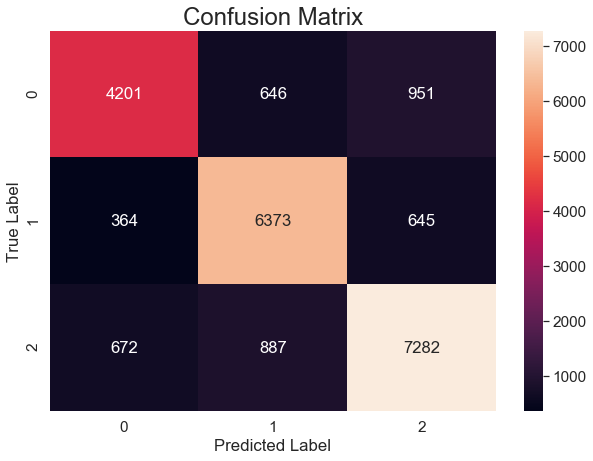

In [231]:
# Apply Confusion matrix

from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test, verbose=2)
y_pred = np.argmax(y_pred, axis=1)

for ix in range(3):
    print(ix, confusion_matrix(np.argmax(y_test, axis=1), y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(cm)

# Visualizing of confusion matrix
import seaborn as sn

df_cm = pd.DataFrame(cm, range(3), range(3))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,fmt='d')
sn.set_context("poster")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig('Plots/confusionMatrix.png')
plt.show()

In [232]:
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras import models


model = load_model('Models/finalsentimentmodelv3.h5')
model.summary()

with open('Models/finalwordindexv3.pkl', 'rb') as picklefile:
    word_index = pickle.load(picklefile)
top_words = len(word_index)
tokenizer = Tokenizer(num_words=top_words)
tokenizer.word_index = word_index
print(word_index)


print('Found %s uniqe tokens.' % len(word_index))





Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         212313200 
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_3 (Activation)    (None, 3)                 0         
Total params: 212,430,835
Trainable params: 117,635
Non-trainable params: 212,313,200
_________________________________________________________________
{'nie': 1, 'm': 2, 'em': 3, 'śmy': 4, 'doktor': 5, 'hotelu': 6, 'polecam': 7, 'hotel': 8, 'dr': 9, 'niestety': 10, 'pokoju': 11, 'obsługa': 12, 'brak': 13, 'pokoje': 14, 'lekarza': 15, 'lekarz': 16, 'ok': 17, 'pokój': 18, 'badania':

In [245]:
# Insert text for example 'your sentence in Polish'
text = ['ogólnie to jest bardzo beznadziejne pozdrawiam']


text[0] = clean_text(text[0])
print(text)

test_sequences = tokenizer.texts_to_sequences(text)

x_test = sequence.pad_sequences(test_sequences, maxlen=40)

print('x_test shape:', str(x_test.shape))
#model.load_weights('Models/finalsentimentmodel.h5')
result = model.predict(x_test)
print(result)
print("Neutral: %.2f%%" % (result[:,0]*100))
print("Positive: %.2f%%" % (result[:,1]*100))
print("Negative: %.2f%%" % (result[:,2]*100))
#print(result)


class_names[np.argmax(result)]


['ogólnie beznadziejne pozdrawiam']
x_test shape: (1, 40)
[[0.5751483  0.11872386 0.30612782]]
Neutral: 57.51%
Positive: 11.87%
Negative: 30.61%


'Neutral'